# Tic tac toe

> Gradient Tree Boosting implementation test

Imports

In [94]:
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    f1_score,
)


Parameters

In [2]:
path_file_ds = './file/ds_tic-tac-toe.data'

# Data parsing parameters
class_positive_str, class_negative_str = 'positive', 'negative'
classes_names = [class_positive_str, class_negative_str]
class_positive, class_negative = 1, 0

play_x_str, play_o_str =  'x', 'o'
play_x, play_o = 1, 0

# Hyper parameters
n_folds = 5
test_size = .2
classes_threshold = .5

max_depth = 4
max_trees = 10
random_state = 10
max_features = None
learning_rate = 0.4


## Import data

In [3]:

# Parse input
features = [f'x{i + 1}' for i in range(9)]
col_y = 'y'

df = pd.read_csv(path_file_ds, header=None)
df.columns = features + [col_y]

def play_to_number(x: str):
    return play_x if x == play_x_str else play_o

def class_to_number(y: str):
    return class_positive if y == class_positive_str else class_negative

# Set working data
y = df[col_y].apply(np.vectorize(class_to_number))
X = df[features].apply(np.vectorize(play_to_number))

# See what we've got
n = len(y)
n_positive = np.sum(y == class_positive)
n_negative = np.sum(y == class_negative)

print(f"{n} samples; Positive cases: {n_positive}; Negative cases: {n_negative};")

958 samples; Positive cases: 626; Negative cases: 332;


## Algorithm Implementation

### Decision Tree

##### Entropy

In [45]:
def get_entropy(values: np.array, log_base: int = 2):
    
    unique_counts = np.bincount(values)
    probabilities = unique_counts / len(values)
    
    summation = 0
    for prob in probabilities:
        if prob > 0:
            summation += prob * math.log(prob, log_base)
    return -summation

##### Log of the Odds

In [120]:
class LogOfOdds():

    def __init__(self, class_pos: int, class_neg: int, values: np.array = np.array([])):
        
        self.class_pos = class_pos
        self.class_neg = class_neg
        
        if values.shape[0] > 0:
            self.from_distribution(values)
        else:
            self.value = 0

    @staticmethod
    def get_prob_from_log(log_odds: float):
        exp_log = math.exp(log_odds)
        return exp_log / (1 + exp_log)
    
    def from_values(self, values: np.array):
        aux = 1e-5
        n_pos = np.where(values == self.class_pos)[0].shape[0] + aux
        n_neg = np.where(values == self.class_neg)[0].shape[0] + aux
        self.value = math.log(n_pos / n_neg)
        return self

    def to_prob(self):
        return LogOfOdds.get_prob_from_log(self.value)

    def __str__(self):
        return str(self.value)


##### Tree

In [138]:
class Tree():

    def __init__(self, classifier: tree.DecisionTreeRegressor, log_odds: list):
        self.classifier = classifier
        self.log_odds = log_odds

    def predict(self, X: np.array) -> np.array:
        '''
            TODO: 2022-07-19 - ADD Description
        '''
        leaves = self.classifier.apply(X)
        leave_to_odds = np.vectorize(lambda leaf: self.log_odds[leaf])
        return leave_to_odds(leaves)


### Gradient Tree Boosting

In [ ]:
class GradientTreeBoosting():
    '''
        TODO: 2022-07-19 - ADD Description
    '''

    def __init__(
        self, 
        max_depth: int = 4,
        max_trees: int = 10,
        max_features: int = None,
        learning_rate: float = 0.4,
        random_state: int = 0,
        epsilon: float = 0,
        class_pos: int = 1,
        class_neg: int = 0,
    ):

        self.epsilon = epsilon
        self.max_depth = max_depth
        self.max_trees = max_trees
        self.max_features = max_features
        self.learning_rate = learning_rate
        self.random_state = random_state
        
        self.class_pos = class_pos
        self.class_neg = class_neg
        
        self._trees = []
        self._log_odds = LogOfOdds(class_pos=self.class_pos, class_neg=self.class_neg)
        self._root_threshold = 0
        

    def fit(self, X: np.array, y: np.array):

        # Set root node value & initialize probabilities
        n = y.shape[0]
        root_log_odds = self._log_odds.from_values(y)
        self._root_threshold = root_log_odds.to_prob()
        
        probs = np.array([self._root_threshold] * n)
        log_odds = np.array([root_log_odds.value] * n)
        
        for _ in range(self.max_trees):

            # Creating a weak learner 
            dt = tree.DecisionTreeRegressor(
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state,
            )

            # Calculate new pseudo residuals
            residuals = y - probs
            is_optimum_tree = np.sum(np.fabs(residuals) < self.epsilon) == n
            if is_optimum_tree:
                break

            # Growing the tree on the residuals
            dt.fit(X, residuals)

            predictions = dt.predict(X)
            leaves = dt.apply(X)
            unique_leaves = np.unique(leaves)

            # Set normalized probability for all predictions in this leaf
            log_odds_norm = np.zeros( (n,) )
            leaves_log_odds = {}

            for leaf in unique_leaves:
                
                leaf_idx = np.where(leaves == leaf)
                leaf_residuals = residuals[leaf_idx]
                
                numerator = np.sum(leaf_residuals)
                denominator = np.sum([p * (1 - p) for p in log_odds[leaf_idx]])
                leaf_log_odds = numerator / denominator
                
                log_odds_norm[leaf_idx] = leaf_log_odds
                leaves_log_odds[leaf] = leaf_log_odds

            # Compute this model
            self._trees.append(Tree(classifier=dt, log_odds=leaves_log_odds))
            log_odds += self.learning_rate * log_odds_norm
            probs = np.vectorize(LogOfOdds.get_prob_from_log)(log_odds)

    def predict(self, X: np.array) -> np.array:
        
        n = X.shape[0]
        log_odds = np.array([self._root_threshold] * n)

        for dt in self._trees:
            log_odds += self.learning_rate * dt.predict(X=X)
        
        y_hat = np.vectorize(LogOfOdds.get_prob_from_log)(log_odds)
        return y_hat


## Evaluate

------------------------------
Fold 1
Train Samples: 766; Test Samples: 192
Accuracy: 0.1639
Precision (average): 0.8801
Recall (average): 0.5264
F1 Score (positive): 0.6465
F1 Score (negative): 0.8772



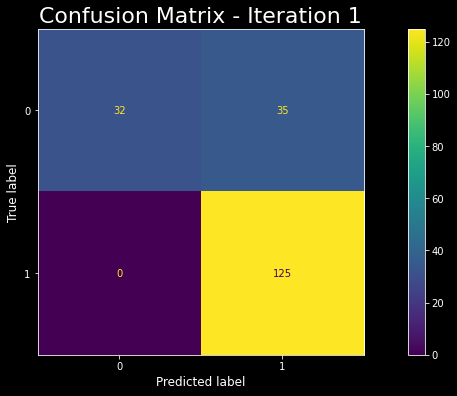

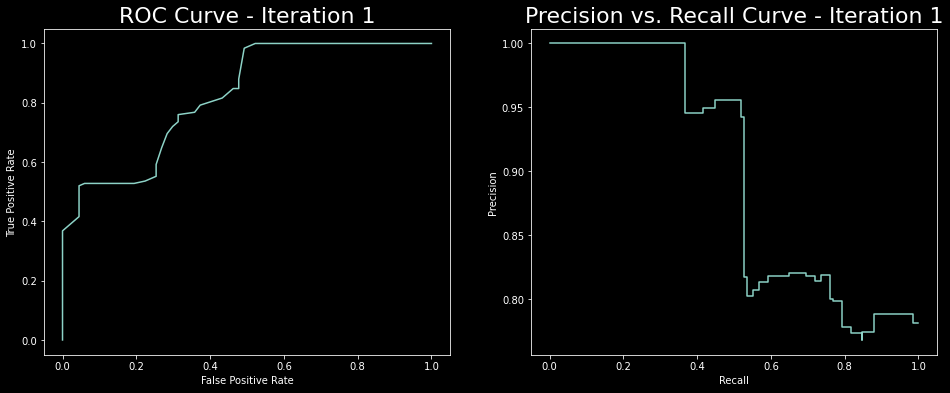

------------------------------
Fold 2
Train Samples: 766; Test Samples: 192
Accuracy: 0.1555
Precision (average): 0.9159
Recall (average): 0.5790
F1 Score (positive): 0.5567
F1 Score (negative): 0.8502



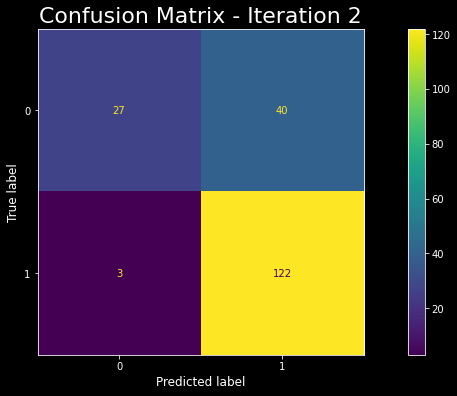

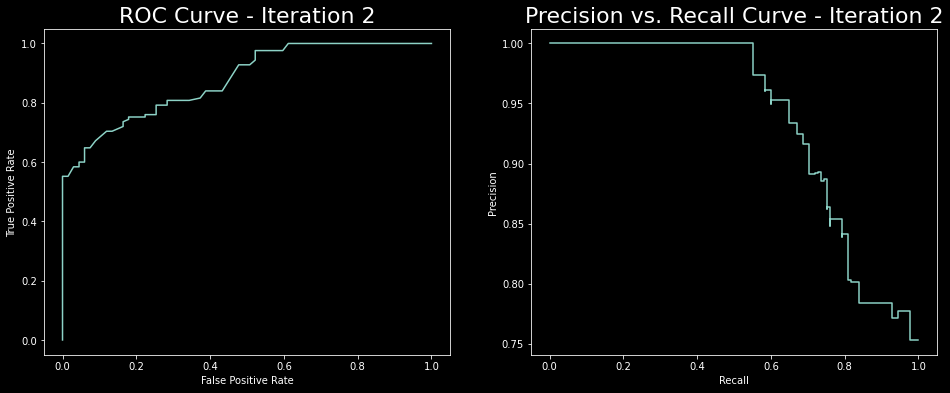

------------------------------
Fold 3
Train Samples: 766; Test Samples: 192
Accuracy: 0.1691
Precision (average): 0.9280
Recall (average): 0.5816
F1 Score (positive): 0.7170
F1 Score (negative): 0.8921



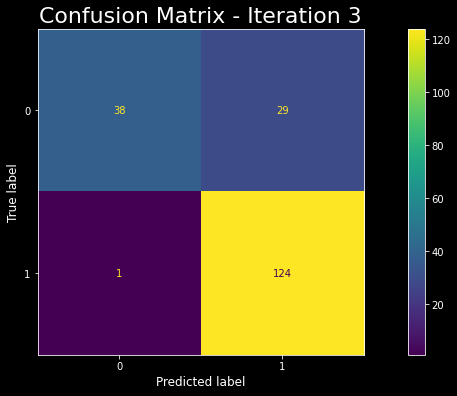

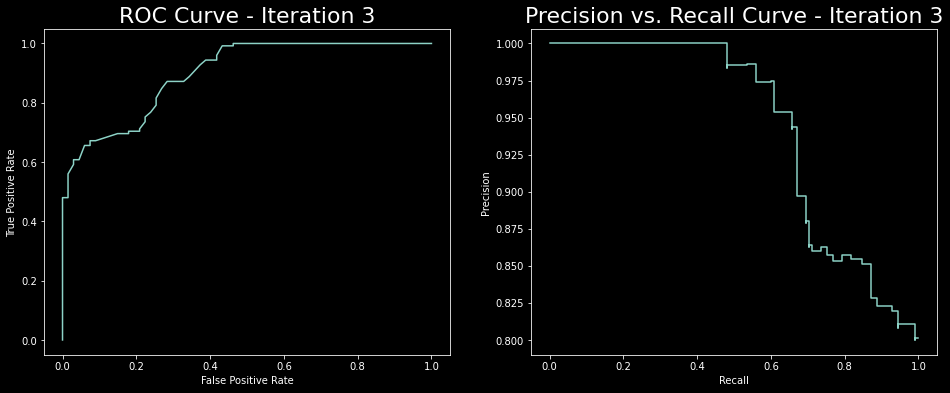

------------------------------
Fold 4
Train Samples: 766; Test Samples: 192
Accuracy: 0.1681
Precision (average): 0.9432
Recall (average): 0.6039
F1 Score (positive): 0.6990
F1 Score (negative): 0.8897



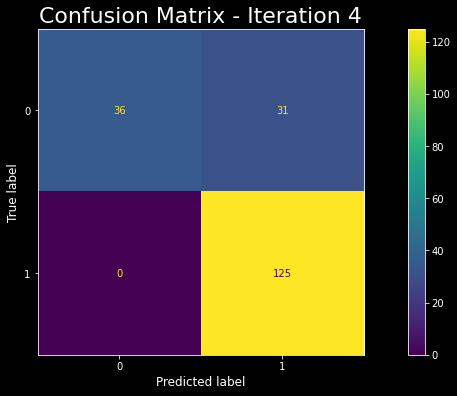

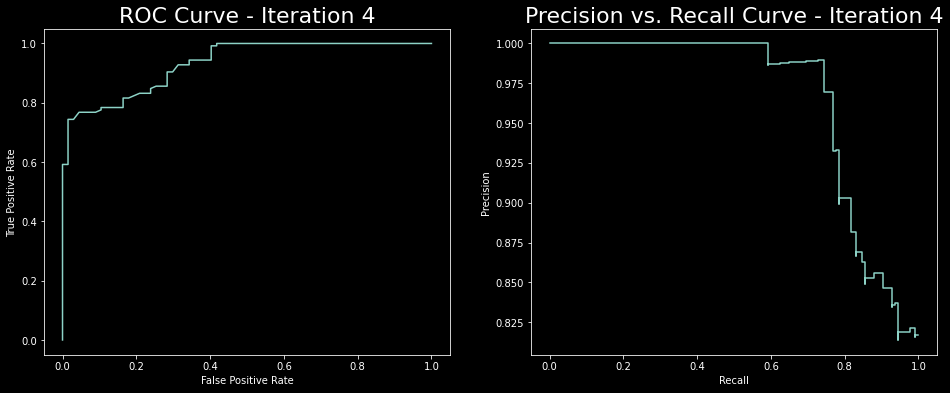

------------------------------
Fold 5
Train Samples: 766; Test Samples: 192
Accuracy: 0.1806
Precision (average): 0.9658
Recall (average): 0.5821
F1 Score (positive): 0.8348
F1 Score (negative): 0.9294



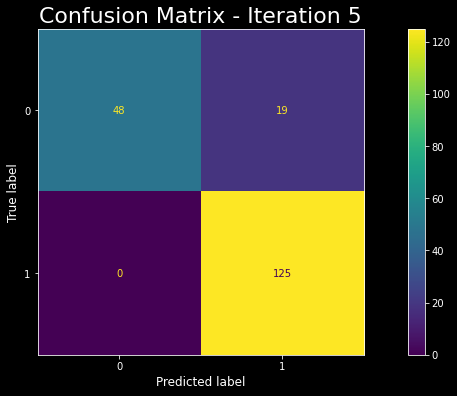

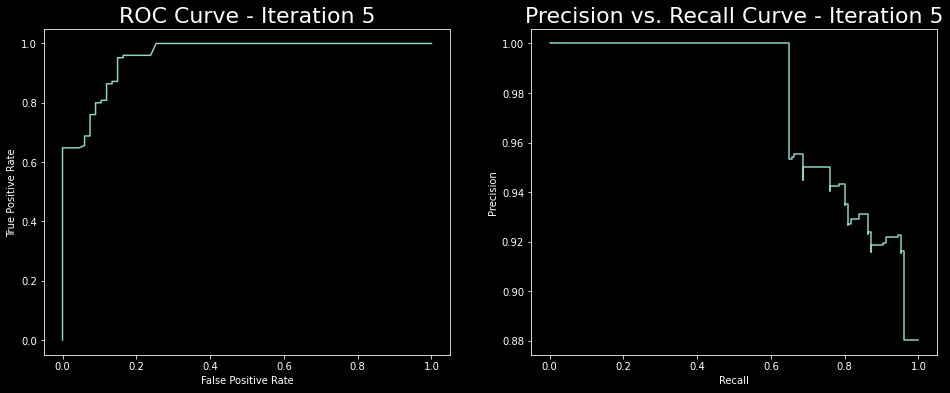

In [139]:
classifier = GradientTreeBoosting(
    # max_depth=max_depth,
    max_depth=4,
    # max_trees=max_trees,
    max_trees=4,
    max_features=max_features,
    # learning_rate=learning_rate,
    learning_rate=.1,
    random_state=random_state,
    epsilon = 1e-3
)

cv = StratifiedShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=random_state)

recalls = np.array([])
accuracies = np.array([])
precisions = np.array([])
f1_scores_pos = np.array([])
f1_scores_neg = np.array([])

i = 0
for train_index, test_index in cv.split(X, y):
    
    # Train & test
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    n_test, n_train = len(test_index), len(train_index)

    classifier.fit(X=X_train, y=y_train)
    outputs = classifier.predict(X=X_test)
    y_hat = (outputs > classes_threshold).astype(int)

    # Evaluate
    accuracy = np.sum(y_hat == y_test) / n
    f1_pos, f1_neg = f1_score(y_test, y_hat, average=None)
    precision, recall, _ = precision_recall_curve(y_test, outputs, pos_label=1)

    # Display summary
    print('-' * 30)
    print(f"Fold {i + 1}")
    print(r"Train Samples: %d; Test Samples: %d" % (n_train, n_test))
    print(r"Accuracy: %.4f" % accuracy)
    print(r"Precision (average): %.4f" % precision.mean())
    print(r"Recall (average): %.4f" % recall.mean())
    print(r"F1 Score (positive): %.4f" % f1_pos)
    print(r"F1 Score (negative): %.4f" % f1_neg)
    print('')

    # Display confusion Matrix
    fig, (ax1) = plt.subplots(1, 1, figsize=(16, 6))
    conf_matrix = confusion_matrix(y_test, y_hat)
    display_conf_matrix = ConfusionMatrixDisplay(conf_matrix)

    plt.title(f'Confusion Matrix - Iteration {i + 1}', fontsize=22)
    plt.xticks(range(2), classes_names, fontsize=10)
    plt.yticks(range(2), classes_names, fontsize=10)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Real', fontsize=12)
    display_conf_matrix.plot(ax=ax1)
    plt.show()
    print('')

    # Display ROC Curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    fpr, tpr, _ = roc_curve(y_test, outputs, pos_label=1)
    display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr)
    ax1.set_title(f'ROC Curve - Iteration {i + 1}', fontsize=22)
    display_roc.plot(ax=ax1)

    # Display Precision x Recall Curve
    display_precision_recall = PrecisionRecallDisplay(precision=precision, recall=recall)
    ax2.set_title(f'Precision vs. Recall Curve - Iteration {i + 1}', fontsize=22)
    display_precision_recall.plot(ax=ax2)
    plt.show()

    # Compute this fold
    recalls = np.append(recalls, recall)
    accuracies = np.append(accuracies, accuracy)
    precisions = np.append(precisions, precision)
    f1_scores_pos = np.append(f1_scores_pos, f1_pos)
    f1_scores_neg = np.append(f1_scores_neg, f1_neg)
    i += 1
    